# Loan Prediction

In [ ]:
!pip install mlflow

In [ ]:
!pip install catboost

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import xgboost as xgb
import mlflow
import mlflow.sklearn

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight


from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


# Functions

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    #print("##################### Tail #####################")
    # print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def target_vs_category_visual(dataframe, target, categorical_col):
    plt.figure(figsize=(15, 8))
    sns.histplot(x=target, hue=categorical_col, data=dataframe, element="step", multiple="dodge")
    plt.title("State of Categorical Variables according to Churn ")
    plt.show()

def cat_summary(dataframe, col_name, plot=False):
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"LOAN STATUS": dataframe.groupby(categorical_col)[target].mean()}))
    print(20 * "-")


def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n")
    print("###################################")


def get_numerical_summary(dataframe):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count / total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [ ]:

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


def quick_missing_imp(dataframe, target, num_method="median", cat_length=20):
    variables_with_na = [col for col in dataframe.columns if
                         dataframe[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = dataframe[target]

    print("# BEFORE")
    print(dataframe[variables_with_na].isnull().sum(),
          "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    dataframe = dataframe.apply(
        lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        dataframe = dataframe.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    dataframe[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(dataframe[variables_with_na].isnull().sum(), "\n\n")

    return dataframe


def outlier_th(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Define a Function about checking outlier for data columns
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_th(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Define a Function about replace with threshold for data columns
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_th(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:

def train_test(X, y, test_size=0.20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    print("Base Models....")
    classifiers = [  #('LR', LogisticRegression()),
        # ('KNN', KNeighborsClassifier()),
        # ("SVC", SVC()),
        ("CART", DecisionTreeClassifier(random_state=0)),
        ("RF", RandomForestClassifier(random_state=0, max_features='sqrt')),
        # ('Adaboost', AdaBoostClassifier(random_state=0)),
         ('GBM', GradientBoostingClassifier(max_depth=4,random_state=0)),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('LightGBM', LGBMClassifier(random_state=0, verbose=-1)),
        ('CatBoost', CatBoostClassifier(verbose=False))
    ]
    print(classifiers)
    return X_train, X_test, y_train, y_test, classifiers

def models(classfiers, X, y):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
        # Calculating Cross-Validation scores for different metrics
        accuracy_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy',n_jobs=-1).mean()
        f1_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='f1',n_jobs=-1).mean()
        precision_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='precision',n_jobs=-1).mean()
        recall_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='recall',n_jobs=-1).mean()

        # Printing Cross-Validation scores
        print(f"Classifier: {name}")
        print("Cross Validation Scores:")
        print("Accuracy : ", '{0:.2%}'.format(accuracy_cv))
        print("F1 : ", '{0:.2%}'.format(f1_cv))
        print("Precision : ", '{0:.2%}'.format(precision_cv))
        print("Recall : ", '{0:.2%}'.format(recall_cv))

        # Accuracy on test data
        test_accuracy = accuracy_score(y_test, prediction)
        print("Test Accuracy : ", '{0:.2%}'.format(test_accuracy))


def model_evaluation(classifiers, X_test, y_test, X_train, y_train):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        cm = confusion_matrix(y_test, classifier.predict(X_test))
        names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        counts = [value for value in cm.flatten()]
        percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
        labels = np.asarray(labels).reshape(2, 2)

        # Her sınıflandırıcı için ayrı bir grafik çiz
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', square=True)
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        # Göster
        plt.show(block=True)

        # Sınıflandırma raporunu yazdır
        print(f'Classification Report for {name}:\n')
        print(classification_report(y_test, classifier.predict(X_test)))


def feature_importances(classifiers, X, y,count=15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(classifier.feature_importances_,
                                index=X.columns).sort_values(ascending=False)[:count]

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Değişken Önem Skorları')
        plt.ylabel('Değişkenler')
        plt.title(name)
        plt.show(block=True)


def hyperparameter_optimization(X, y, classifiers, cv=5, main_scoring='accuracy'):
    print("Hyperparameter Optimization....")
    best_models = {}
    scoring_metrics = ['accuracy', 'f1', 'recall', 'precision']

    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")

        initial_scores = {}
        for metric in scoring_metrics:
            cv_results = cross_validate(classifier, X, y, cv=cv, scoring=metric)
            mean_score = round(cv_results['test_score'].mean(), 4)
            initial_scores[metric] = mean_score
            print(f"{metric} (Before): {mean_score}")

        # GridSearchCV ile hiperparametre optimizasyonu
        # RandomSearchCV
        gs_best = RandomizedSearchCV(classifier, params, cv=cv, scoring=main_scoring, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)
        print(f"{name} best params: {gs_best.best_params_}")

        # Optimizasyon sonrası skorları hesaplama
        optimized_scores = {}
        for metric in scoring_metrics:
            cv_results = cross_validate(final_model, X, y, cv=cv, scoring=metric)
            mean_score = round(cv_results['test_score'].mean(), 4)
            optimized_scores[metric] = mean_score
            print(f"{metric} (After): {mean_score}")

        best_models[name] = {
            'final_model': final_model,
            'initial_scores': initial_scores,
            'optimized_scores': optimized_scores
        }

    return best_models

# Reading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loan_train = pd.read_csv("/content/drive/MyDrive/loan_dataset/train.csv")
loan_test = pd.read_csv("/content/drive/MyDrive/loan_dataset/test.csv")


In [ ]:
df = pd.concat([loan_train, loan_test], ignore_index=True)
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.0


# Exploratory Data Analysis

In [ ]:
check_df(df)

##################### Shape #####################
(97743, 13)
##################### Types #####################
id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                   float64
dtype: object
##################### Head #####################
   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30      

In [ ]:
df.describe([0.25,0.5,0.7,0.8,0.85,0.9,0.95,0.99]).T

,count,mean,std,min,25%,50%,70%,80%,85%,90%,95%,99%,max
id,97743.0,48871.000000,28216.118018,0.00,24435.50,48871.00,68419.40,78193.60,83080.70,87967.80,92854.90,96764.58,97742.00
person_age,97743.0,27.557227,6.033008,20.00,23.00,26.00,29.00,31.00,33.00,36.00,39.00,49.00,123.00
person_income,97743.0,64051.888176,37940.804312,4000.00,42000.00,58000.00,72000.00,83004.00,90000.00,100000.00,120000.00,172290.00,1900000.00
person_emp_length,97743.0,4.695436,3.923469,0.00,2.00,4.00,6.00,7.00,8.00,10.00,12.00,17.00,123.00
loan_amnt,97743.0,9231.120663,5568.786009,500.00,5000.00,8000.00,11000.00,13000.00,15000.00,16000.00,20000.00,25000.00,35000.00
loan_int_rate,97743.0,10.671211,3.028910,5.42,7.88,10.75,12.53,13.49,13.98,14.65,15.68,17.49,23.22
loan_percent_income,97743.0,0.159372,0.091668,0.00,0.09,0.14,0.20,0.23,0.25,0.29,0.34,0.42,0.83
cb_person_cred_hist_length,97743.0,5.820417,4.046423,2.00,3.00,4.00,7.00,9.00,10.00,11.00,14.00,17.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00


In [ ]:
df['loan_status'].value_counts()

,count
loan_status,
0.0,50295
1.0,8350


# Summarize for Categorical Columns

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

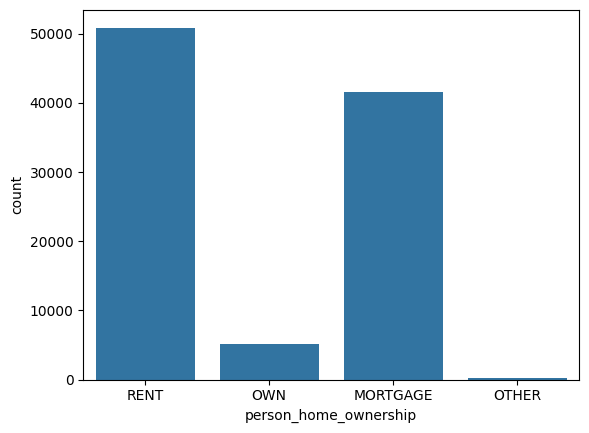

                       person_home_ownership      Ratio
person_home_ownership                                  
RENT                                   50874  52.048740
MORTGAGE                               41507  42.465445
OWN                                     5194   5.313936
OTHER                                    168   0.171879
##########################################


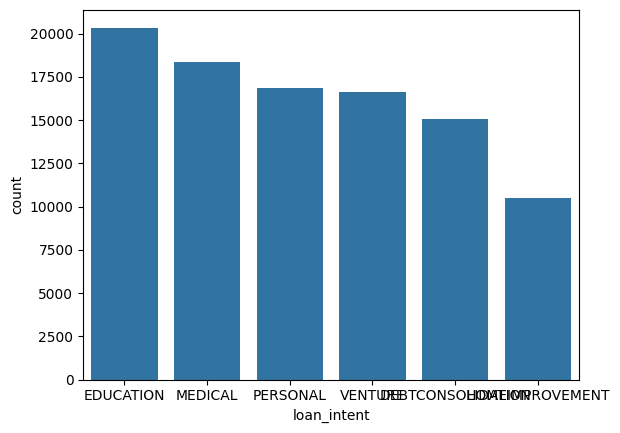

                   loan_intent      Ratio
loan_intent                              
EDUCATION                20347  20.816836
MEDICAL                  18381  18.805439
PERSONAL                 16831  17.219647
VENTURE                  16643  17.027306
DEBTCONSOLIDATION        15048  15.395476
HOMEIMPROVEMENT          10493  10.735296
##########################################


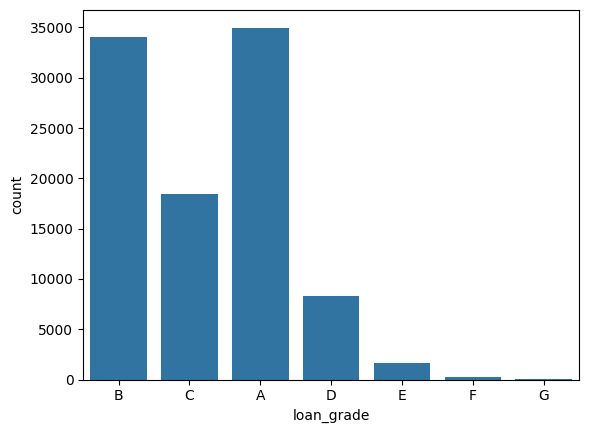

            loan_grade      Ratio
loan_grade                       
A                34989  35.796937
B                34004  34.789192
C                18496  18.923094
D                 8303   8.494726
E                 1646   1.684008
F                  254   0.259865
G                   51   0.052178
##########################################


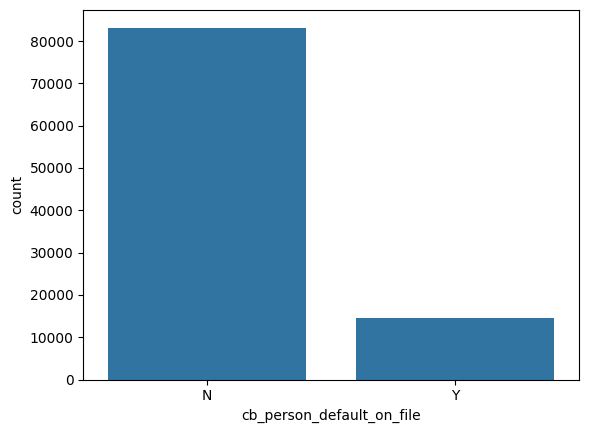

                           cb_person_default_on_file      Ratio
cb_person_default_on_file                                      
N                                              83170  85.090492
Y                                              14573  14.909508
##########################################


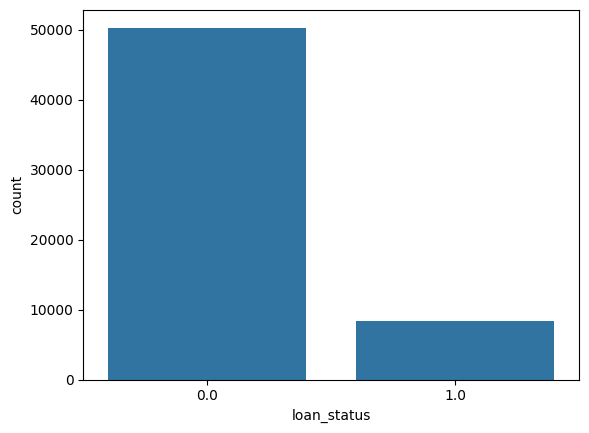

             loan_status      Ratio
loan_status                        
0.0                50295  51.456370
1.0                 8350   8.542811
##########################################


In [ ]:
for col in cat_cols:
    cat_summary(df, col,plot=True)

In [ ]:
for col in cat_cols:
    target_summary_with_cat(df,"loan_status",col)

                       LOAN STATUS
person_home_ownership             
MORTGAGE                  0.059741
OTHER                     0.168539
OWN                       0.013703
RENT                      0.222560
--------------------
                   LOAN STATUS
loan_intent                   
DEBTCONSOLIDATION     0.189313
EDUCATION             0.107734
HOMEIMPROVEMENT       0.173726
MEDICAL               0.178251
PERSONAL              0.132788
VENTURE               0.092798
--------------------
            LOAN STATUS
loan_grade             
A              0.049180
B              0.102304
C              0.135375
D              0.593564
E              0.625372
F              0.610738
G              0.818182
--------------------
                           LOAN STATUS
cb_person_default_on_file             
N                             0.115111
Y                             0.298897
--------------------
             LOAN STATUS
loan_status             
0.0                  0.0
1.0        

# Notes

* Person_Home_Ownership degiskeninde Rent bilgisini tasiyanlarin Loan olma durumu daha yüksek

*   Loan Grade degeri D, E, F ve G bilgisini tasiyanlarin Loan olma durumu yüksek.
*   Loan_Intent degiskenine göre DebtConsolidation, Home Improvement ve Medical olanlarin Loan olma sinifi daha belirgin.



# Summarize for Numerical Columns

In [ ]:
for col in num_cols:
    target_summary_with_num(df,"loan_status",col)

                       id
loan_status              
0.0          29378.138682
1.0          28983.856886

###################################
             person_age
loan_status            
0.0           27.553634
1.0           27.534132

###################################
             person_income
loan_status               
0.0           66672.867720
1.0           48224.661796

###################################
             person_emp_length
loan_status                   
0.0                   4.863048
1.0                   3.725030

###################################
                loan_amnt
loan_status              
0.0           8888.883229
1.0          11197.271856

###################################
             loan_int_rate
loan_status               
0.0              10.258767
1.0              13.202305

###################################
             loan_percent_income
loan_status                     
0.0                     0.145105
1.0                     0.244363

#

# Notes

*   Person Income degeri düsük olanlarin Loan olma durumu daha yüksek.
*   Loan_Int_Rate ortalama 13 civarinda olanlarin Loan olma durumu yüksek.



# Correlation

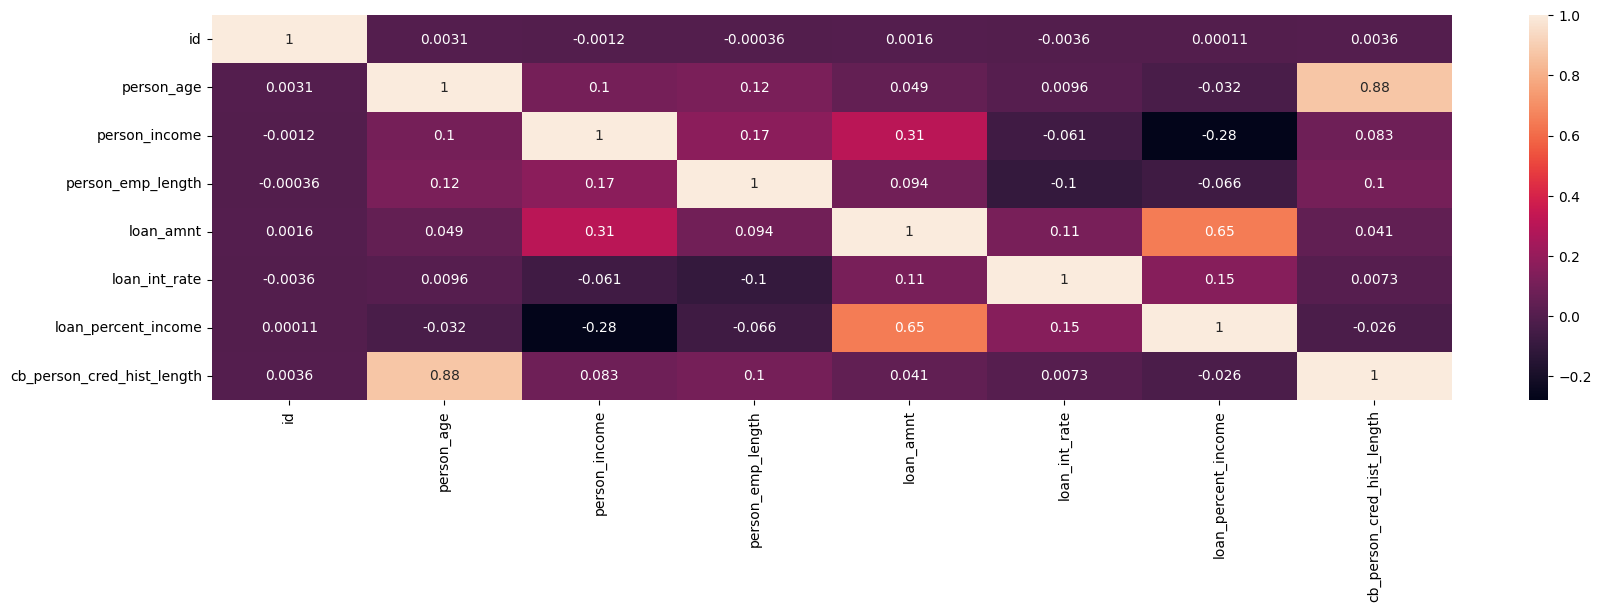

In [ ]:
plt.figure(figsize = (20,5))
sns.heatmap(df[num_cols].corr(),annot = True);

In [ ]:
corr_matrix = df[num_cols].corr()
corr_matrix

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
id,1.000000,0.003112,-0.001164,-0.000363,0.001559,-0.003621,0.000115,0.003611
person_age,0.003112,1.000000,0.101155,0.119667,0.049155,0.009595,-0.031707,0.875050
person_income,-0.001164,0.101155,1.000000,0.167854,0.308679,-0.061426,-0.279478,0.082850
person_emp_length,-0.000363,0.119667,0.167854,1.000000,0.094258,-0.101817,-0.065734,0.102515
loan_amnt,0.001559,0.049155,0.308679,0.094258,1.000000,0.111932,0.650116,0.041444
loan_int_rate,-0.003621,0.009595,-0.061426,-0.101817,0.111932,1.000000,0.154163,0.007270
loan_percent_income,0.000115,-0.031707,-0.279478,-0.065734,0.650116,0.154163,1.000000,-0.026394
cb_person_cred_hist_length,0.003611,0.875050,0.082850,0.102515,0.041444,0.007270,-0.026394,1.000000


# Data Visualization

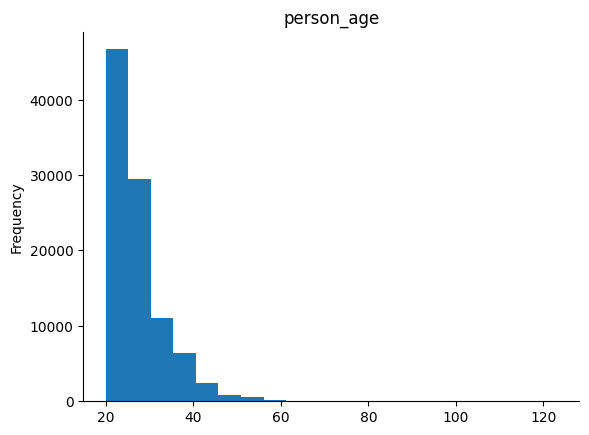

In [ ]:
# @title person_age

from matplotlib import pyplot as plt
df['person_age'].plot(kind='hist', bins=20, title='person_age')
plt.gca().spines[['top', 'right',]].set_visible(False)

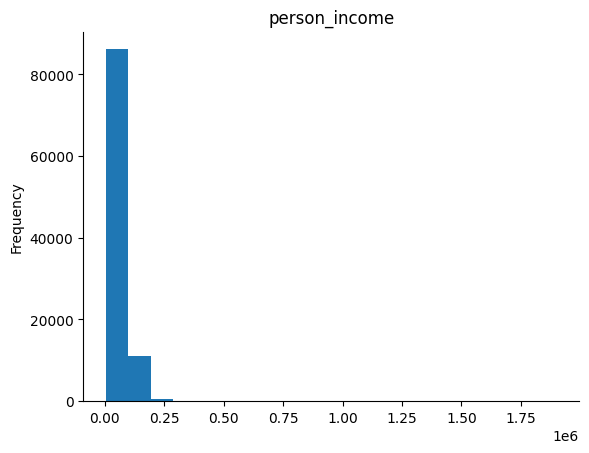

In [ ]:
# @title person_income

from matplotlib import pyplot as plt
df['person_income'].plot(kind='hist', bins=20, title='person_income')
plt.gca().spines[['top', 'right',]].set_visible(False)

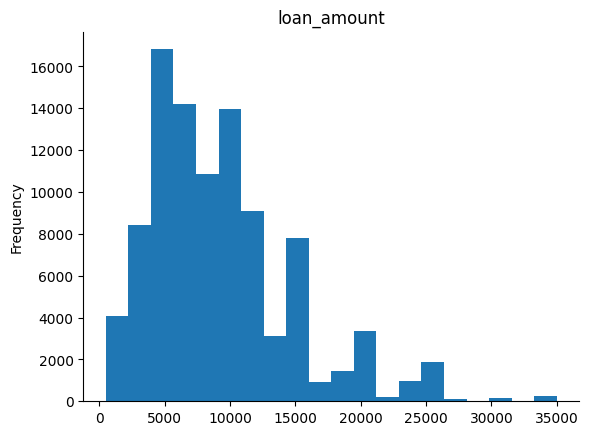

In [ ]:
# @title loan_amount

from matplotlib import pyplot as plt
df['loan_amnt'].plot(kind='hist', bins=20, title='loan_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

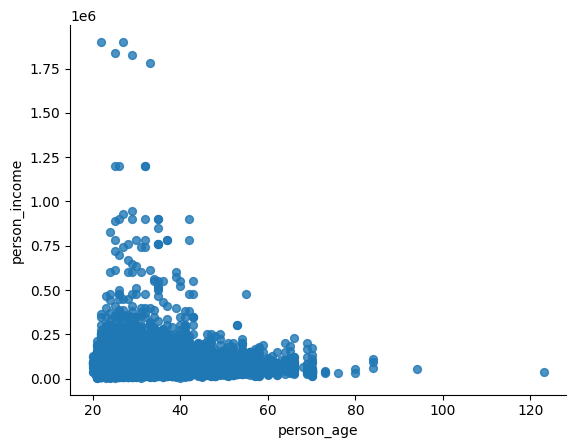

In [ ]:
# @title person_age vs person_income

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='person_age', y='person_income', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

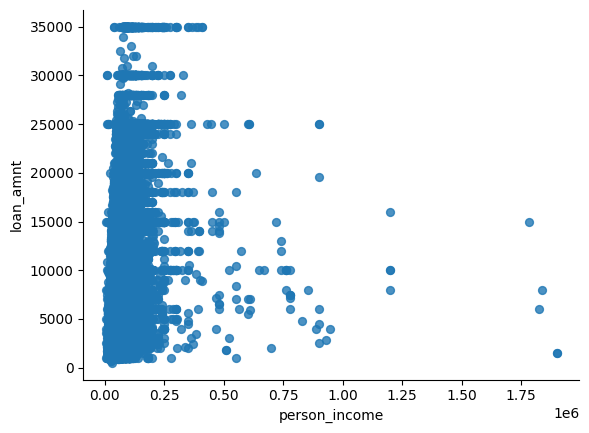

In [ ]:
# @title person_income vs loan_amount

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='person_income', y='loan_amnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'loan_status']

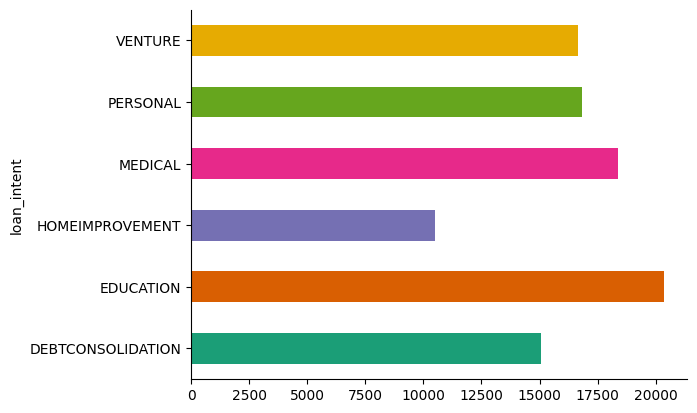

In [ ]:
# @title loan_intent

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('loan_intent').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

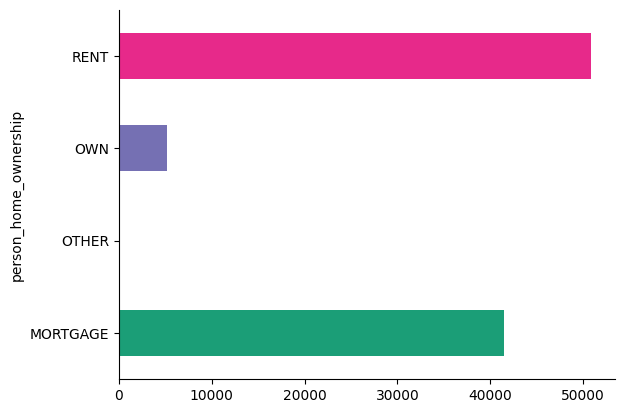

In [ ]:
# @title person_hole_ownership

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('person_home_ownership').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

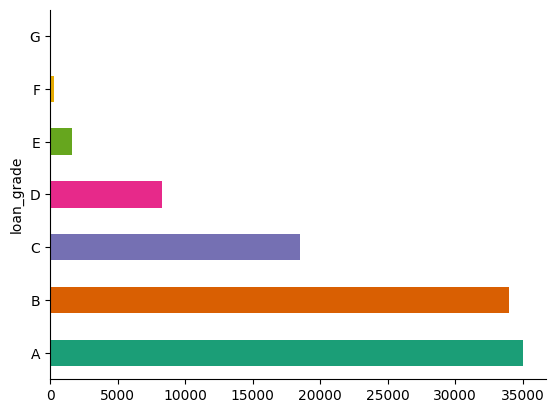

In [ ]:
# @title loan_grade

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('loan_grade').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

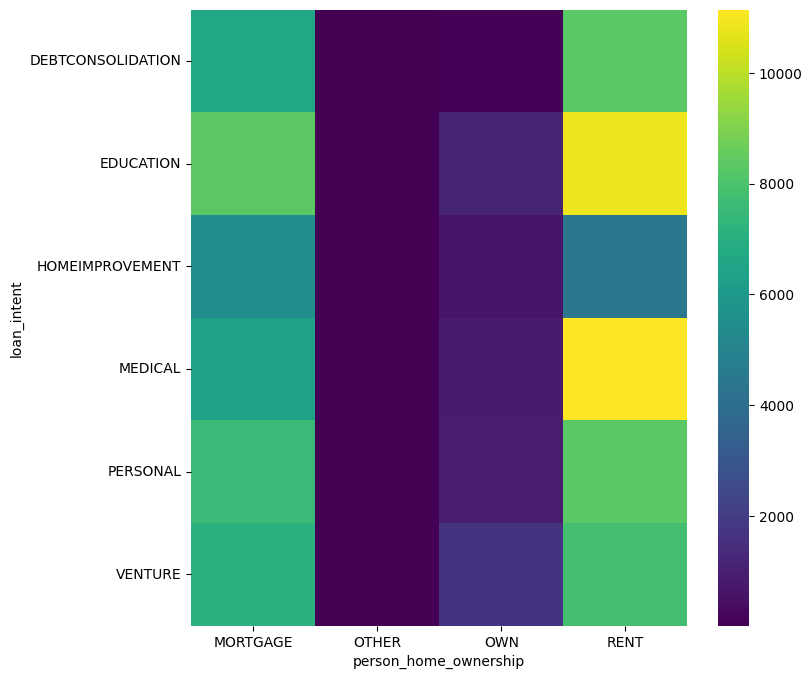

In [ ]:
# @title person_home_ownership vs loan_intent

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['loan_intent'].value_counts()
    for x_label, grp in df.groupby('person_home_ownership')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('person_home_ownership')
_ = plt.ylabel('loan_intent')

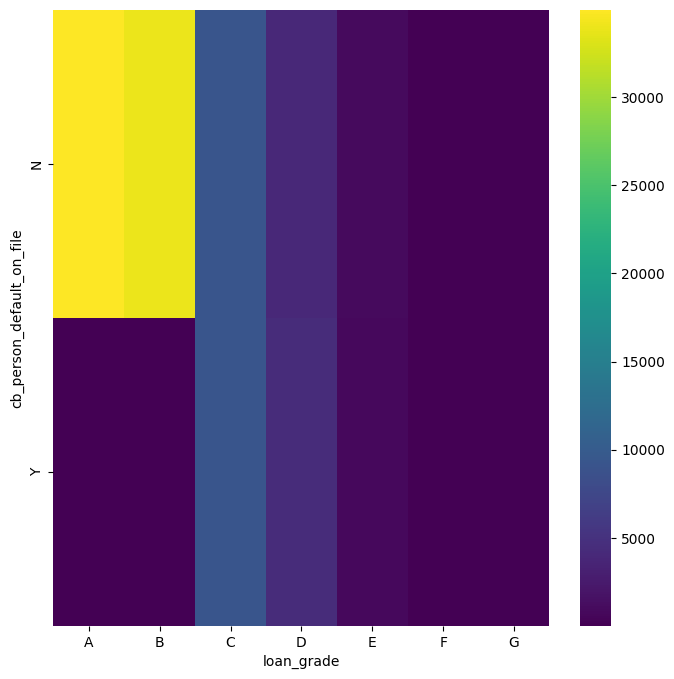

In [ ]:
# @title loan_grade vs cb_person_default_on_file

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['cb_person_default_on_file'].value_counts()
    for x_label, grp in df.groupby('loan_grade')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('loan_grade')
_ = plt.ylabel('cb_person_default_on_file')

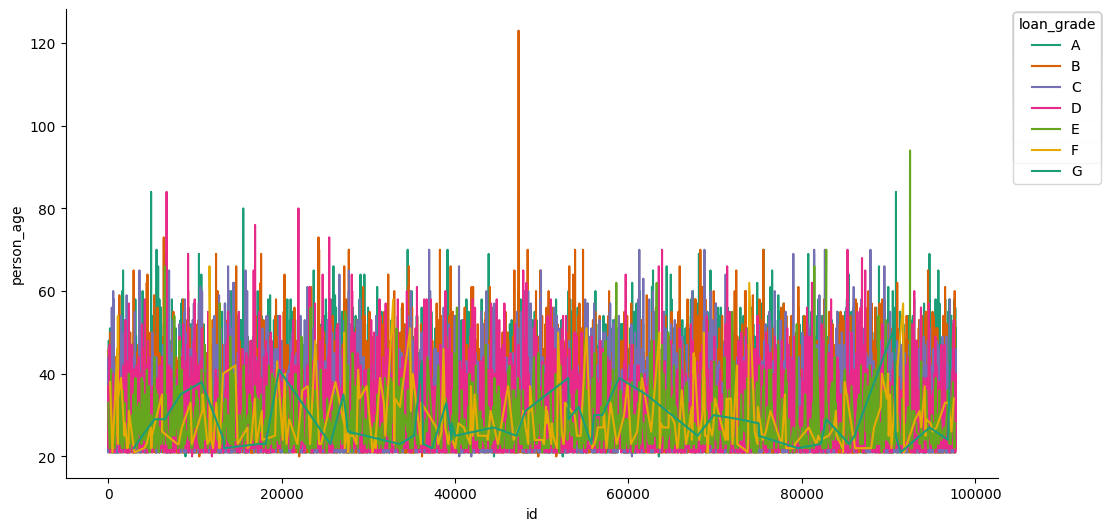

In [ ]:
# @title id vs person_age

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['person_age']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('loan_grade')):
  _plot_series(series, series_name, i)
  fig.legend(title='loan_grade', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('person_age')

# Data Preparation

In [ ]:
missing_values_table(df)

             n_miss  ratio
loan_status   39098   40.0


In [ ]:
df.isnull().sum()

,0
id,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0


In [ ]:
num_cols

['id',
 'person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [ ]:
for col in num_cols:
    print(col, check_outlier(df, col))

id False
person_age True
person_income True
person_emp_length True
loan_amnt False
loan_int_rate False
loan_percent_income True
cb_person_cred_hist_length False


In [ ]:
for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

id False
person_age False
person_income False
person_emp_length False
loan_amnt False
loan_int_rate False
loan_percent_income False
cb_person_cred_hist_length False


# Encoding

In [ ]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [ ]:
binary_cols

['cb_person_default_on_file']

In [ ]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [ ]:
df = one_hot_encoder(df, ohe_cols)

In [ ]:
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,-1.000000,1.571429,-0.681603,-0.8,-0.285714,0.144814,0.250000,2.0
1,-0.999980,-0.571429,-0.059270,0.4,-0.571429,0.508806,-0.583333,-0.4
2,-0.999959,0.428571,-0.865339,0.8,-0.285714,-0.362035,0.583333,1.2
3,-0.999939,0.571429,0.355619,2.0,0.571429,0.070450,0.250000,0.2
4,-0.999918,-0.571429,0.059270,-0.4,-0.285714,-0.749511,-0.333333,-0.2


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
df.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,-1.000000,1.571429,-0.681603,-0.8,-0.285714,0.144814,0.250000,N,2.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,-0.999980,-0.571429,-0.059270,0.4,-0.571429,0.508806,-0.583333,N,-0.4,0.0,...,True,False,False,False,False,True,False,False,False,False
2,-0.999959,0.428571,-0.865339,0.8,-0.285714,-0.362035,0.583333,N,1.2,0.0,...,False,True,False,True,False,False,False,False,False,False
3,-0.999939,0.571429,0.355619,2.0,0.571429,0.070450,0.250000,N,0.2,0.0,...,False,False,True,False,True,False,False,False,False,False
4,-0.999918,-0.571429,0.059270,-0.4,-0.285714,-0.749511,-0.333333,N,-0.2,0.0,...,True,False,False,True,False,False,False,False,False,False


# Modeling

In [ ]:
df1 = df[df['loan_status'].notnull()]


In [ ]:
df1.isnull().sum()

,0
id,0
person_age,0
person_income,0
person_emp_length,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0
cb_person_cred_hist_length,0
loan_status,0


In [ ]:
df1.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,-1.000000,1.571429,-0.681603,-0.8,-0.285714,0.144814,0.250000,N,2.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,-0.999980,-0.571429,-0.059270,0.4,-0.571429,0.508806,-0.583333,N,-0.4,0.0,...,True,False,False,False,False,True,False,False,False,False
2,-0.999959,0.428571,-0.865339,0.8,-0.285714,-0.362035,0.583333,N,1.2,0.0,...,False,True,False,True,False,False,False,False,False,False
3,-0.999939,0.571429,0.355619,2.0,0.571429,0.070450,0.250000,N,0.2,0.0,...,False,False,True,False,True,False,False,False,False,False
4,-0.999918,-0.571429,0.059270,-0.4,-0.285714,-0.749511,-0.333333,N,-0.2,0.0,...,True,False,False,True,False,False,False,False,False,False


In [ ]:
y = df1["loan_status"]
X = df1.drop(["loan_status","cb_person_default_on_file"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test,classifiers = train_test(X,y)

Base Models....
[('CART', DecisionTreeClassifier(random_state=0)), ('RF', RandomForestClassifier(random_state=0)), ('GBM', GradientBoostingClassifier(max_depth=4, random_state=0)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)), ('LightGBM', LGBMClassifier(random_state=0

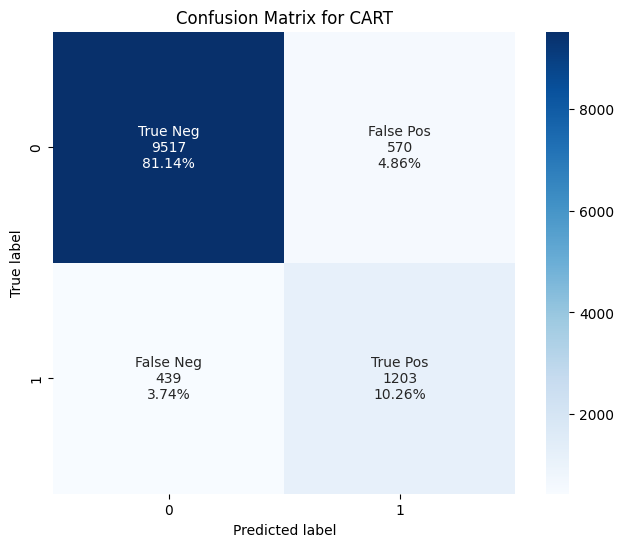

Classification Report for CART:

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     10087
         1.0       0.68      0.73      0.70      1642

    accuracy                           0.91     11729
   macro avg       0.82      0.84      0.83     11729
weighted avg       0.92      0.91      0.92     11729



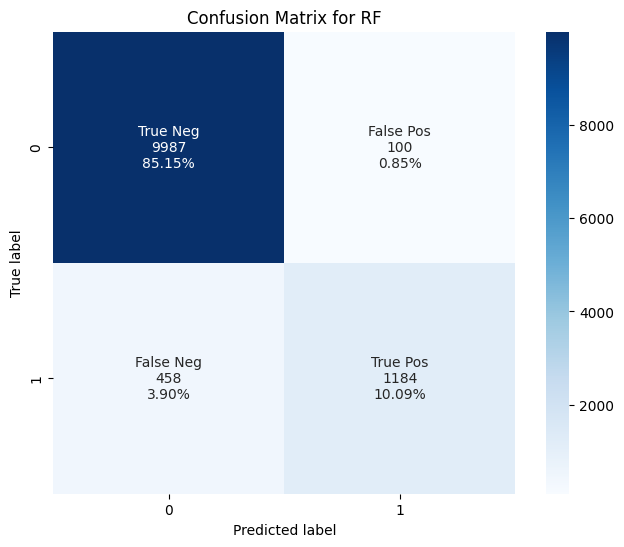

Classification Report for RF:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10087
         1.0       0.92      0.72      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



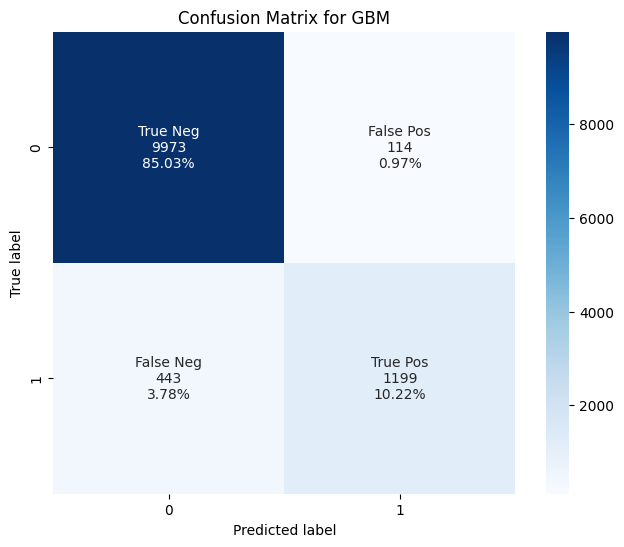

Classification Report for GBM:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10087
         1.0       0.91      0.73      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:29:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


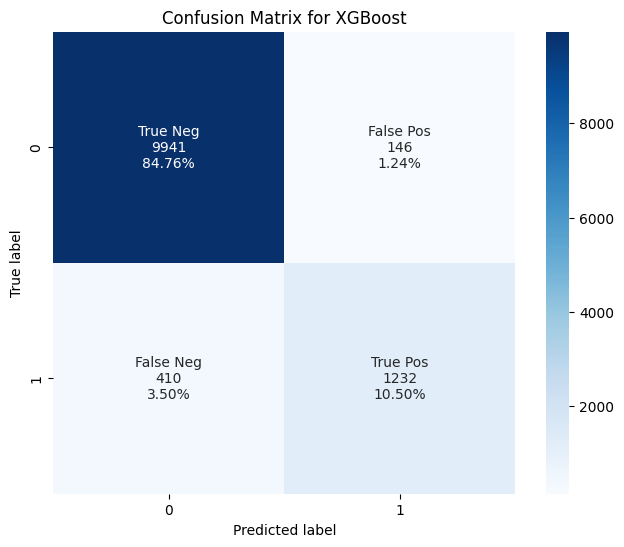

Classification Report for XGBoost:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10087
         1.0       0.89      0.75      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.87      0.89     11729
weighted avg       0.95      0.95      0.95     11729



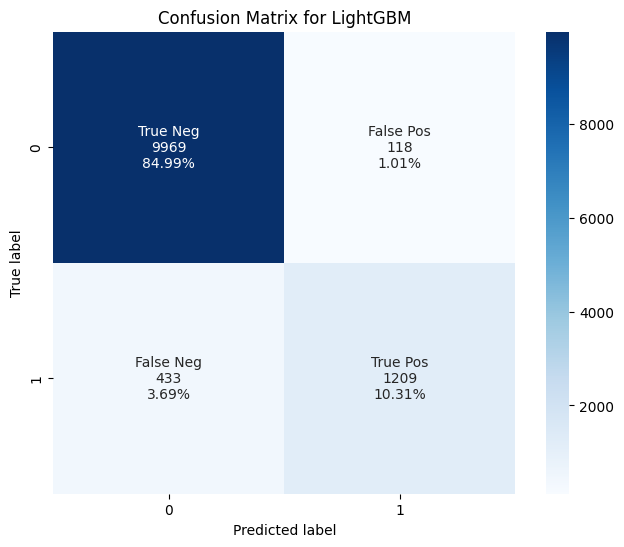

Classification Report for LightGBM:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10087
         1.0       0.91      0.74      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



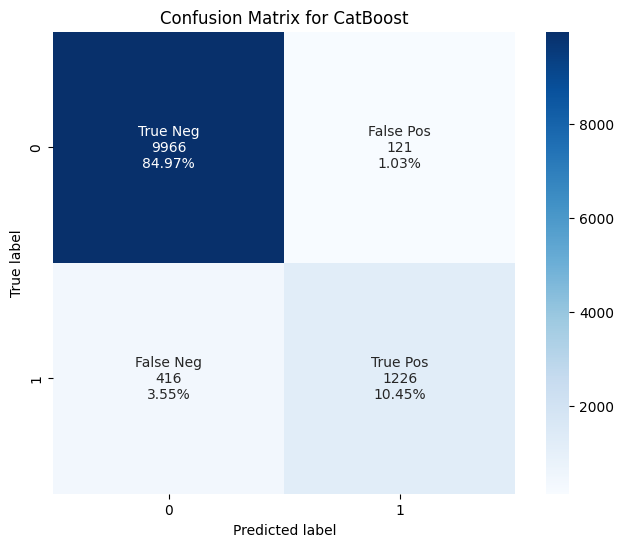

Classification Report for CatBoost:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10087
         1.0       0.91      0.75      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.87      0.90     11729
weighted avg       0.95      0.95      0.95     11729



In [ ]:
# Model success evaluation with Hold-Out via the complexity matrix
model_evaluation(classifiers,X_test,y_test,X_train,y_train)

In [ ]:
# Model success evaluation with K-Fold Cross Validation
models(classifiers,X,y)

Classifier: CART
Cross Validation Scores:
Accuracy :  91.20%
F1 :  69.93%
Precision :  68.40%
Recall :  71.54%
Test Accuracy :  91.40%
Classifier: RF
Cross Validation Scores:
Accuracy :  95.11%
F1 :  80.47%
Precision :  93.74%
Recall :  70.50%
Test Accuracy :  95.24%
Classifier: GBM
Cross Validation Scores:
Accuracy :  95.14%
F1 :  80.77%
Precision :  92.99%
Recall :  71.39%
Test Accuracy :  95.25%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:36:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classifier: XGBoost
Cross Validation Scores:
Accuracy :  95.05%
F1 :  80.74%
Precision :  90.94%
Recall :  72.60%
Test Accuracy :  95.26%
Classifier: LightGBM
Cross Validation Scores:
Accuracy :  95.20%
F1 :  81.05%
Precision :  93.17%
Recall :  71.72%
Test Accuracy :  95.30%
Classifier: CatBoost
Cross Validation Scores:
Accuracy :  95.31%
F1 :  81.60%
Precision :  92.85%
Recall :  72.78%
Test Accuracy :  95.42%


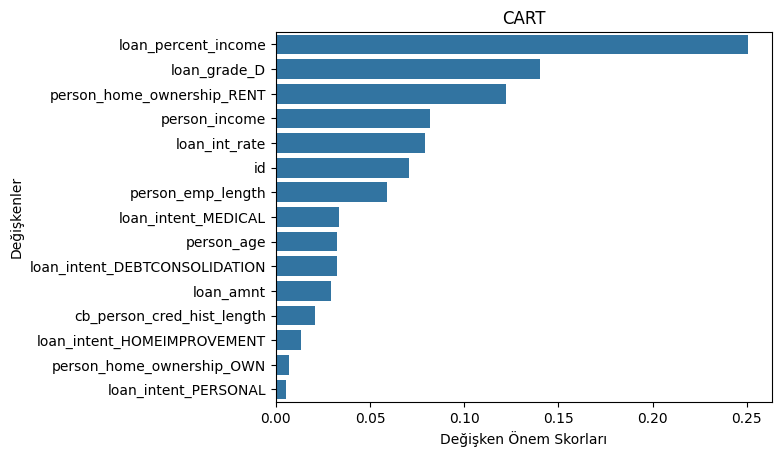

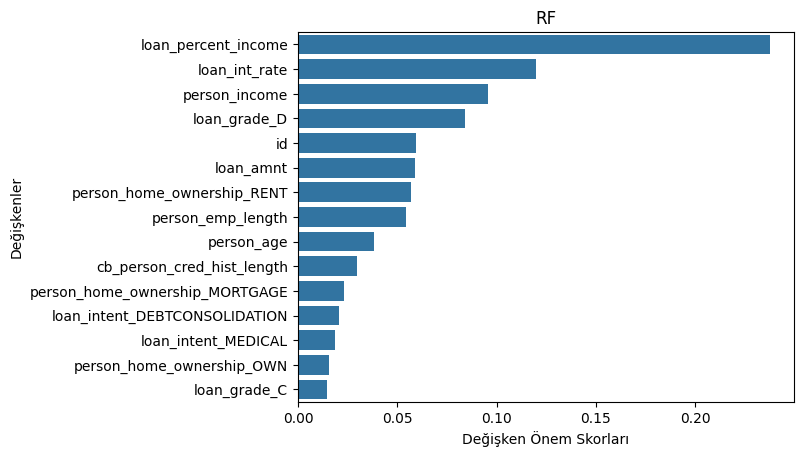

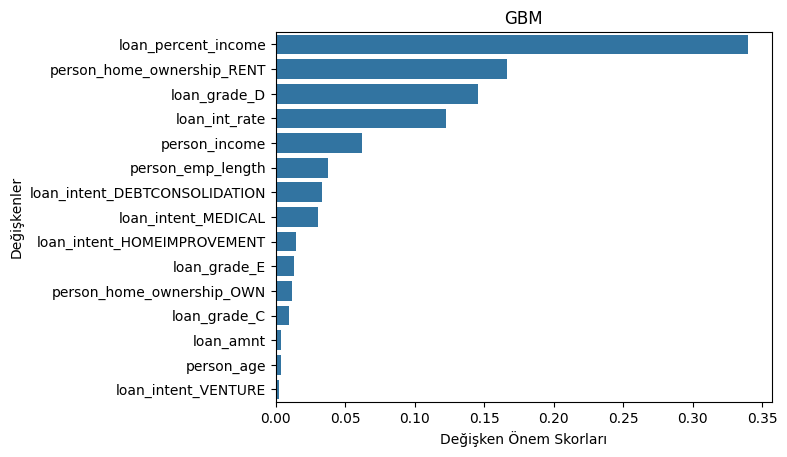

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:43:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


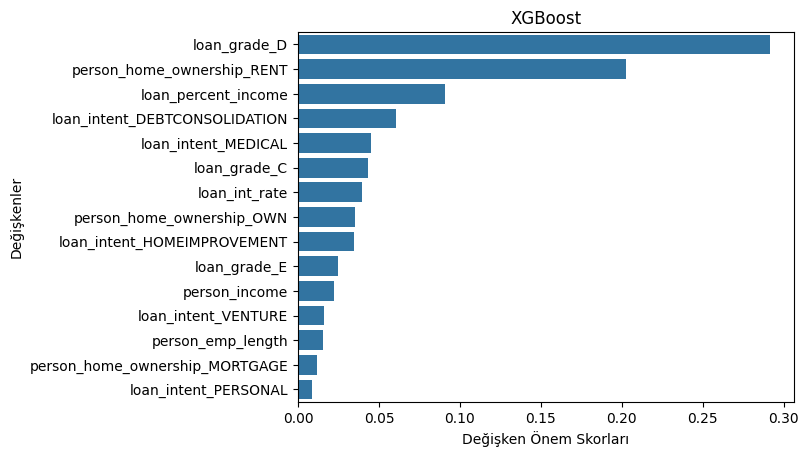

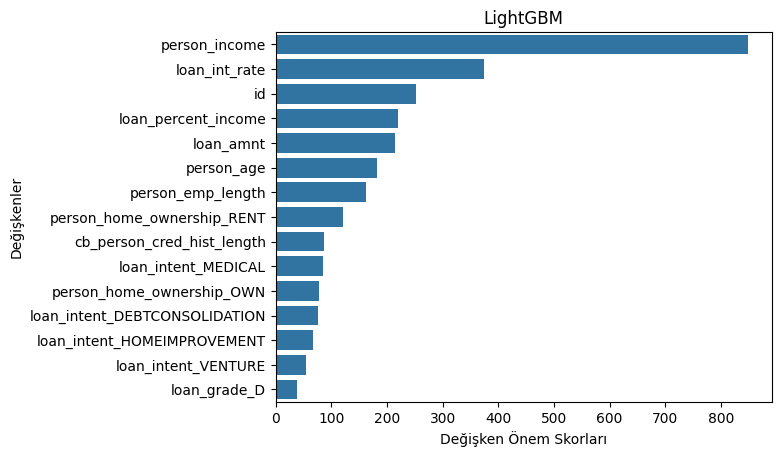

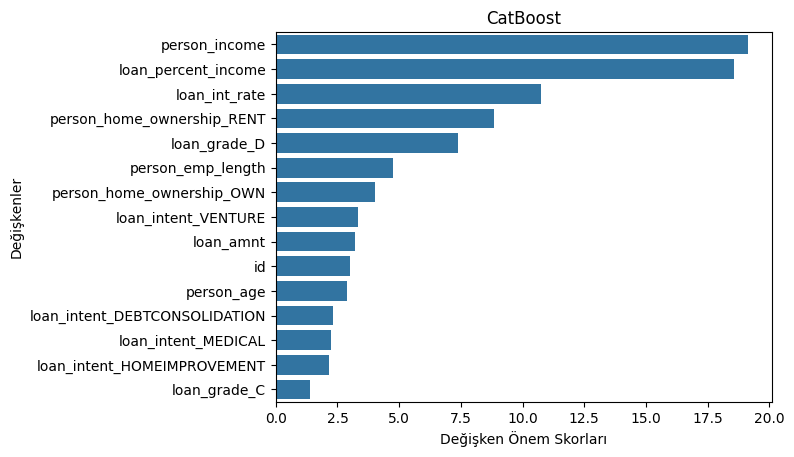

In [ ]:
feature_importances(classifiers,X,y,count=15)

# Hyperparameter Optimization

In [ ]:
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30) }

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "sqrt"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300,500]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100,200,500],
                  "colsample_bytree": [0.5, 1],}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500,1000],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 250, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128, 255],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced']
}

classifiers = [#('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(random_state=42), cart_params),
               ("RF", RandomForestClassifier(random_state=42), rf_params),
               ('XGBoost', xgb.XGBClassifier(eval_metric='logloss',random_state=42), xgboost_params),
               ('LightGBM', LGBMClassifier(random_state=42,verbose=-1), lightgbm_params),
                ('CatBoost', CatBoostClassifier(verbose=False),catboost_params)]


In [ ]:
#best_models = hyperparameter_optimization(X,y,classifiers)

# Optimization Result

In [ ]:
# model_results_df = pd.DataFrame(columns=['Model', 'Metric', 'Before Optimization', 'After Optimization'])

# for name, model_info in best_models.items():
#    for metric in model_info['initial_scores']:
#        before_score = model_info['initial_scores'][metric]
#        after_score = model_info['optimized_scores'][metric]
#        model_results_df = model_results_df.append({
#            'Model': name,
#            'Metric': metric,
#            'Before Optimization': before_score,
#            'After Optimization': after_score
#        }, ignore_index=True)

# print(model_results_df)